## Exercise 13 Structured light

These exercises will introduce you to a 3D scanning pipeline using the phase shifting encoding. In \
this exercise you will use code for phase shift decoding, phase matching, and triangulation. Also, \
this time you will have some real images to play with.

### Data set - Casper
The images are in the folder sequence. The first number indicates which camera it is from (0 or 1) and the second number describes the image, where:
- 0 is an image fully illuminated by the projector (projector showing a white image)
- 1 is an image with the projector fully off

Also:
- 2-17 are the 16 images in the primary pattern shifting. This pattern has 40 periods.
- 18-25 are the 8 images of the secondary pattern shifting. This pattern has 41 periods.

For example, frames1_0.png is the image from camera 1 that is fully illuminated by the projector.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

path = "week13_data/casper/";

In [4]:
c = np.load(path + "calib.npy", allow_pickle=True).item()
# load intrinsic camera matrices, distortion matrices and extrinsic rotation and translation.
K0 = c["K0"]
d0 = c["d0"]
K1 = c["K1"]
d1 = c["d1"]
R1 = c["R"]
t1 = c["t"]
# Organize in dictionary
K = {0: K0, 1: K1}
d = {0: d0, 1: d1}

#### 13.1 Calibration
If the cameras were not calibrated, you would need to calibrate them first. \
How would you find their **intrinsics**? \
What about the **extrinsics**?


- Use changs method to calibrate cameras.
- Intrinsics: in K matrix. Extrinsic: R and T.

#### 13.2 Rectify images

First we need to rectify the images. First run the following code to initialize the maps for rectification:
```Python
        im0 = cv2.imread("sequence/frames0_0.png")
        size = (im0.shape[1], im0.shape[0])
        stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
        c['d1'], size, c['R'], c['t'], flags=0)
        R0, R1, P0, P1 = stereo[:4]
        maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
        maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)
```
You can now rectify images by doing cv2.remap(im, *maps, cv2.INTER_LINEAR), where maps  \
is either maps0 or maps1 depending on which camera the image is coming from. This also handles \
the undistortion of the images. P0 and P1 are the projection matrices for the rectified images, \
which will come in handy when we need to triangulate the points in 3D.

Now for each image:
- load it,
- convert it gray-scale and floating point, and
- rectify it.

Store the resulting images in two lists (ims0 and ims1), one for each camera. \
Show ims0[0] and ims1[0] side-by-side and verify visually that the images have been rectified.

In [5]:
def grayscale(im):
    return np.sum(im, axis=2) / 3

In [6]:
ims0, ims1 = [], []
n_patterns = 26
for pattern in range(n_patterns):
    im0 = grayscale(cv2.imread(path + f"sequence/frames{0}_{pattern}.png"))
    im1 = grayscale(cv2.imread(path + f"sequence/frames{1}_{pattern}.png"))
    size = (im0.shape[1], im0.shape[0])
    stereo = cv2.stereoRectify(
        c['K0'],
        c['d0'],
        c['K1'],
        c['d1'],
        size,
        c['R'],
        c['t'],
        flags=0
    )
    R0, R1, P0, P1 = stereo[:4]
    maps0 = cv2.initUndistortRectifyMap(
        c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2
    )
    maps1 = cv2.initUndistortRectifyMap(
        c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2
    )
    ims0.append(cv2.remap(im0, *maps0, cv2.INTER_LINEAR))
    ims1.append(cv2.remap(im1, *maps1, cv2.INTER_LINEAR))

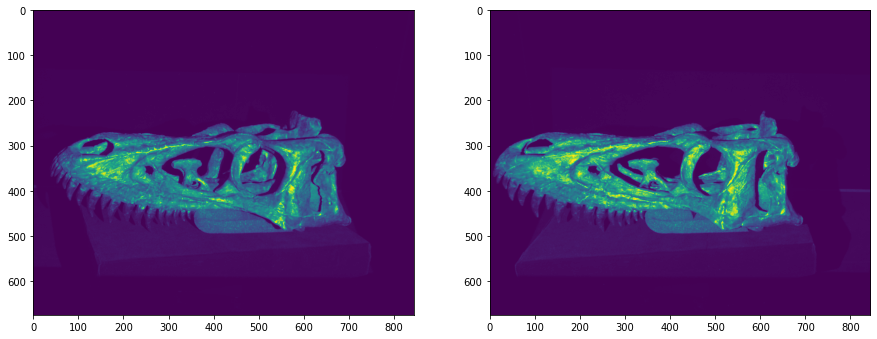

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(ims0[0])
ax[1].imshow(ims1[0]);

#### 13.4 Unwrapping the phases.

$\theta = unwrap(ims)$. We are ready to make a function that can compute the phases for each camera.\

Use indexing to get a list of the primary images out, and make sure it has length 16. Put this \
list into the Fast Fourier Transform (np.fft.rfft) to find the Fourier spectrums of the primary \
images (fft_primary). We use rfft as the input is only real numbers. The function can operate \
on a list of arrays, which is ideal for our situation. Make sure to specify that the FFT should \
operate along the first dimension of the array (axis=0).

The Fourier component corresponding to the pattern is in the second component (fft_primary[1]).
Get the phase of this using np.angle and call it theta_primary.

Repeat the same steps for the secondary phase to obtain theta_secondary. Compute the phase
cue (theta_c) using the heterodyne principle.

Find the order (o_primary) of the primary phase.
Use the order of the primary phase to obtain the unwrapped phase (theta).

Wrap all of the above into a function theta = unwrap(ims) and use it to obtain the phase for
both cameras (theta0 and theta1).


In [22]:
def unwrap(ims, n1=40):
    """
    Compute the phases for each camera.

    Parameters
    ----------
    ims: primary images
    """
    # Use FFT to fit sinusioidal curves to observed light intensity
    # Do this for both primary and secondary data.
    # Extract the phase/angle information.
    fft_primary = np.fft.rfft(ims[2:18], axis=0)
    theta_primary = np.angle(fft_primary[1])

    fft_secondary = np.fft.rfft(ims[18:26], axis=0)
    theta_secondary = np.angle(fft_secondary[1])

    # Use hetrodyne principle to get phase cue.
    # Cannot use direrctly as it has bad noise characteristics
    theta_c = (theta_primary - theta_secondary) % (2 * np.pi)

    # Find order of primary signal: Number of times it wraps
    o_primary = np.rint((n1 * theta_c - theta_primary) / 2 / np.pi)

    # Estimate the actual phase of signal using the order
    theta = ((2 * np.pi * o_primary + theta_primary) / n1) % (2 * np.pi)
    
    return theta


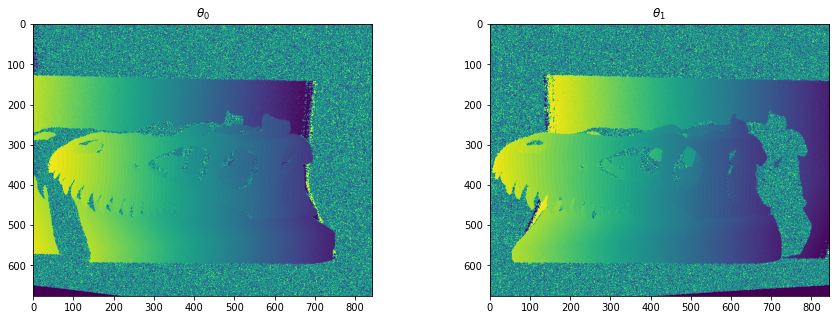

In [28]:
theta0 = unwrap(ims0) # Camera 1 phase
theta1 = unwrap(ims1) # Camera 2 phase

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(theta0);
ax[0].set_title(r"$\theta_0$")
ax[1].imshow(theta1);
ax[1].set_title(r"$\theta_1$");

**The phase** umiquely identifies each column of the image (where possible, where light has shone).

#### 13.4 Binary masking

When inspecting the phase images theta0 and theta1 it is clear that not all pixels contain a valid measurement of the phase.

This is because some pixels do not reflect enough light from the projector to give a meaningful measurement.

To fix this we introduce a binary mask that contains the areas that are sufficiently illuminated by the projector.

Subtract the fully on and fully off projector image from each other (the first two elements of ims), to obtain a measurement of how much projector light is in each pixel.
 
Apply a threshold to this difference image to obtain a mask for each camera (mask0 and mask1). I suggest using a threshold of 15.


In [33]:
mask0 = (ims0[0] - ims0[1]) > 15 # Camera 0
mask1 = (ims1[0] - ims1[1]) > 15 # Camera 1

theta0_masked = theta0.copy()
theta1_masked = theta1.copy()

# ~ : not -  removing where this is not the case
theta0_masked[~mask0] = 0 
theta1_masked[~mask1] = 0

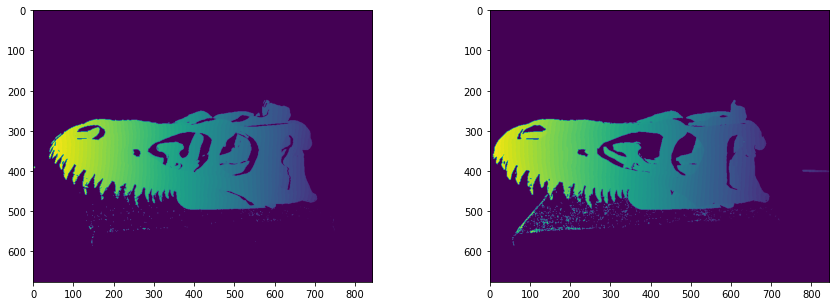

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(theta0_masked);
ax[1].imshow(theta1_masked);

#### 13.5 Point matches

Now we need to find matches between the two cameras. As the images are rectified, we can \
constrain ourselves to search for a match on the corresponding row in the other image. That is \
we need to create two lists (q0s and q1s) that contain the pixel coordinates of matches between \
camera 0 and 1.

Use a double for-loop to iterate over all pixels in camera 0. For each valid pixel:
 
(mask0[i0,j0] = True 

which has the phase theta0[i0,j0]), we need to find the pixel in the other image that \
matches the best. As the images are rectified the epipolar line is a the row i0 in camera 1. Thus, we \
find the matching pixel in camera 1, **selecting the pixel from row i0 which is valid mask1[i0,j1]** \
= True **and which has the closest phase match: theta0[i0,j0] ∼ theta1[i0,j1].**

We need to store the points as (x, y) i.e. [j, i]


To verify your matches you can compute the disparity image. This is the image such that \
disparity[i0,j0] = j0-j1 for all valid pixels. Initialize it with 0 everywhere, and fill it where \
you have matches.

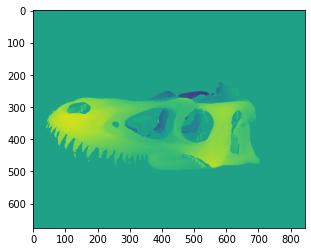

In [35]:
h, w = theta0_masked.shape
disparity = np.zeros((h, w)) # Disparity map
matches0 = []
matches1 = []
# Iterate over all pixels
for i in range(h): # ROW
    for j0 in range(w): # COL
        # Mask is valid
        if mask0[i, j0]:
            # Choose closest valid match, using the 
            min_disp = None
            for j1 in range(w):
                # Disparity along same row.
                disp = theta0_masked[i, j0] - theta1_masked[i, j1]
                if min_disp is None or np.abs(disp) < min_disp:
                    disparity[i, j0] = j0 - j1
                    min_disp = np.abs(disp)
                    j_opt = j1
            # Given valid mask in other frame as well
            if mask1[i, j_opt]:
                # For valid pixel in camera0, a match in camera1
                matches0.append([j0, i])
                matches1.append([j_opt, i])

# Apply median blurr to reduce noise of disparity
plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5));

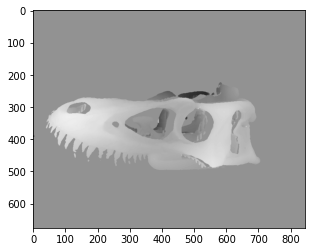

In [36]:
# Apply median blurr to reduce noise of disparity
plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5), cmap="gray");

#### 13.6 Triangulation

Finally, use the matches from the previous exercise and triangulate the 3D points, using the \
projection matrices P0 and P1 from Exercise 13.2. To triangulate you can use your own function \
or cv2.triangulatePoints. For the OpenCV function you need to convert your lists to arrays, \
transpose them, and convert them to floating point. The output of cv2.triangulatePoints is in \
homogeneous coordinates.



Visualize your points in 3D by doing (press [ESC] to close the window again)
```Python
        import open3d as o3d
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(Q.T)
        o3d.visualization.draw_geometries([pcd])
```

In [41]:
# Put matches in numpy arrays, and cast to float!
# Also, cv2.triangulatePoints expects 2XN pixel coordinates; transpose.
matches0 = np.array(matches0, dtype=np.float32).T
matches1 = np.array(matches1, dtype=np.float32).T
matches0.shape, matches1.shape

((2, 112643), (2, 112643))

In [42]:
# Built in triangulation chosen over my own :D
Q = cv2.triangulatePoints(P0, P1, matches0, matches1)
# Convert to non-homogenous
Q = Q[:-1] / Q[-1]

In [45]:

#Visualize using open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])

![image.png](Casper_1.png)